# `PyMC` - Data SAO 185716

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

import scipy.special as sc
from scipy.interpolate import interp1d
from astropy import units as u
from skyfield.api import load
import pymc as pm
import arviz as az

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op

az.style.use("arviz-darkgrid")
# plt.style.use(['science', 'notebook'])
# plt.style.use(['science', 'notebook', 'grid'])
pd.set_option('display.float_format',  '{:}'.format)

In [2]:
df = pd.read_csv("sao185716.csv", sep=',')
df.head()

FrameNum            timeInfo  signal-obj  appsum-obj  avgbkg-obj  \
0    5000.0  [13:45:10.2013390]     95143.0    535552.0    20971.88   
1    5001.0  [13:45:10.2114387]     74148.0    450992.0    20935.77   
2    5002.0  [13:45:10.2215383]     72501.0    408000.0    20968.68   
3    5003.0  [13:45:10.2316380]     95052.0    515200.0    21007.38   
4    5004.0  [13:45:10.2417377]     59529.0    332096.0    20966.67   

   stdbkg-obj  nmaskpx-obj  maxpx-obj  xcentroid-obj  ycentroid-obj  
0     1283.77           21      32384         359.19         202.38  
1     1289.02           18      30880         359.78         202.72  
2     1305.09           16      33696         359.38         202.81  
3     1317.24           20      35296          359.4          203.3  
4     1302.76           13      30048         359.69         202.62

In [3]:
# hilangkan karakter [ dan ] dari data
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']')))

# ubah ke format waktu dan ambil tanggal dan jamnya
df['timeInfo'] = pd.to_datetime(df['timeInfo'])

df.head()

FrameNum                   timeInfo  signal-obj  appsum-obj  avgbkg-obj  \
0    5000.0 2022-08-10 13:45:10.201339     95143.0    535552.0    20971.88   
1    5001.0 2022-08-10 13:45:10.211438     74148.0    450992.0    20935.77   
2    5002.0 2022-08-10 13:45:10.221538     72501.0    408000.0    20968.68   
3    5003.0 2022-08-10 13:45:10.231638     95052.0    515200.0    21007.38   
4    5004.0 2022-08-10 13:45:10.241737     59529.0    332096.0    20966.67   

   stdbkg-obj  nmaskpx-obj  maxpx-obj  xcentroid-obj  ycentroid-obj  
0     1283.77           21      32384         359.19         202.38  
1     1289.02           18      30880         359.78         202.72  
2     1305.09           16      33696         359.38         202.81  
3     1317.24           20      35296          359.4          203.3  
4     1302.76           13      30048         359.69         202.62

In [4]:
data = df[['FrameNum','timeInfo','signal-obj']]
data.columns = ['Frame','Date', 'Value']
data.head()

Frame                       Date   Value
0 5000.0 2022-08-10 13:45:10.201339 95143.0
1 5001.0 2022-08-10 13:45:10.211438 74148.0
2 5002.0 2022-08-10 13:45:10.221538 72501.0
3 5003.0 2022-08-10 13:45:10.231638 95052.0
4 5004.0 2022-08-10 13:45:10.241737 59529.0

In [5]:
data_cp = data.copy() # buat copy dari dataframe asli

data_cp['JD'] = Time(data_cp['Date']).jd

data_cp['frac_JD'] = data_cp['JD'] - np.floor(data_cp['JD']).astype(int)
data_cp

Frame                       Date   Value                 JD  \
0    5000.0 2022-08-10 13:45:10.201339 95143.0 2459802.0730347377   
1    5001.0 2022-08-10 13:45:10.211438 74148.0 2459802.0730348546   
2    5002.0 2022-08-10 13:45:10.221538 72501.0 2459802.0730349715   
3    5003.0 2022-08-10 13:45:10.231638 95052.0 2459802.0730350884   
4    5004.0 2022-08-10 13:45:10.241737 59529.0 2459802.0730352052   
...     ...                        ...     ...                ...   
1996 6996.0 2022-08-10 13:45:30.370452  2011.0 2459802.0732681765   
1997 6997.0 2022-08-10 13:45:30.380552  2242.0 2459802.0732682934   
1998 6998.0 2022-08-10 13:45:30.390652  2700.0 2459802.0732684103   
1999 6999.0 2022-08-10 13:45:30.400751 -1193.0  2459802.073268527   
2000 7000.0 2022-08-10 13:45:30.410851  3546.0  2459802.073268644   

                 frac_JD  
0    0.07303473772481084  
1    0.07303485460579395  
2    0.07303497148677707  
3    0.07303508836776018  
4     0.0730352052487433  
...                  ...  
1996 0.07326817652210593  
1997 0.07326829340308905  
1998 0.07326841028407216  
1999 0.07326852716505527  
2000 0.07326864404603839  

[2001 rows x 5 columns]

Text(0.5, 0, 'Frames')

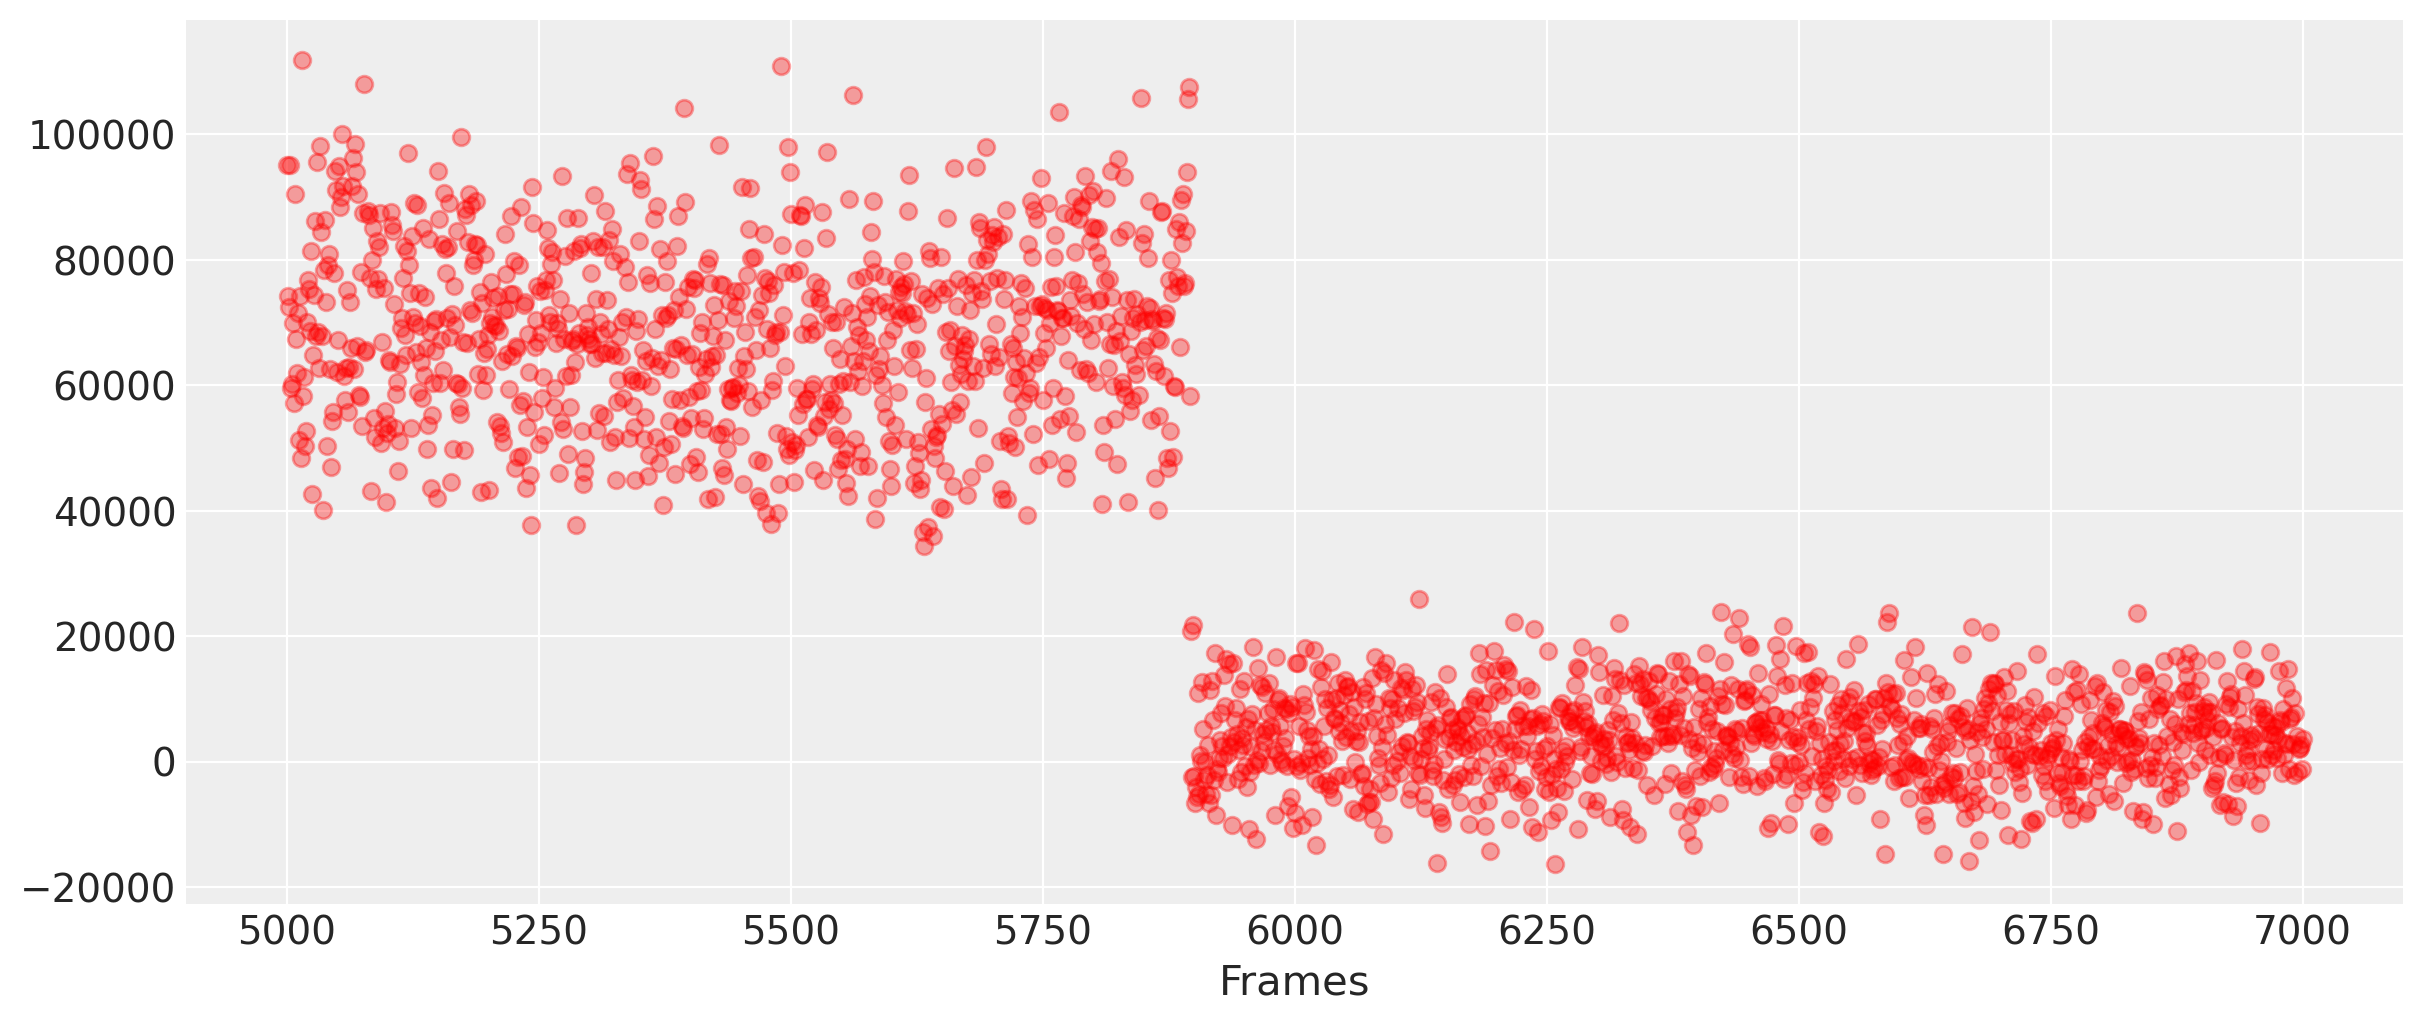

In [6]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(data_cp['Frame'], data_cp['Value'], 'ro', alpha=0.35)
# ax.set_xlim(3300, 3700)
ax.set_xlabel('Frames')

## Normalisasi

In [7]:
def Normalisasi(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) 

In [8]:
# value_scaled = Normalisasi(data['Value'])
value_scaled = data['Value']/(data['Value'].std()*2)

Text(0.5, 0, 'Frames')

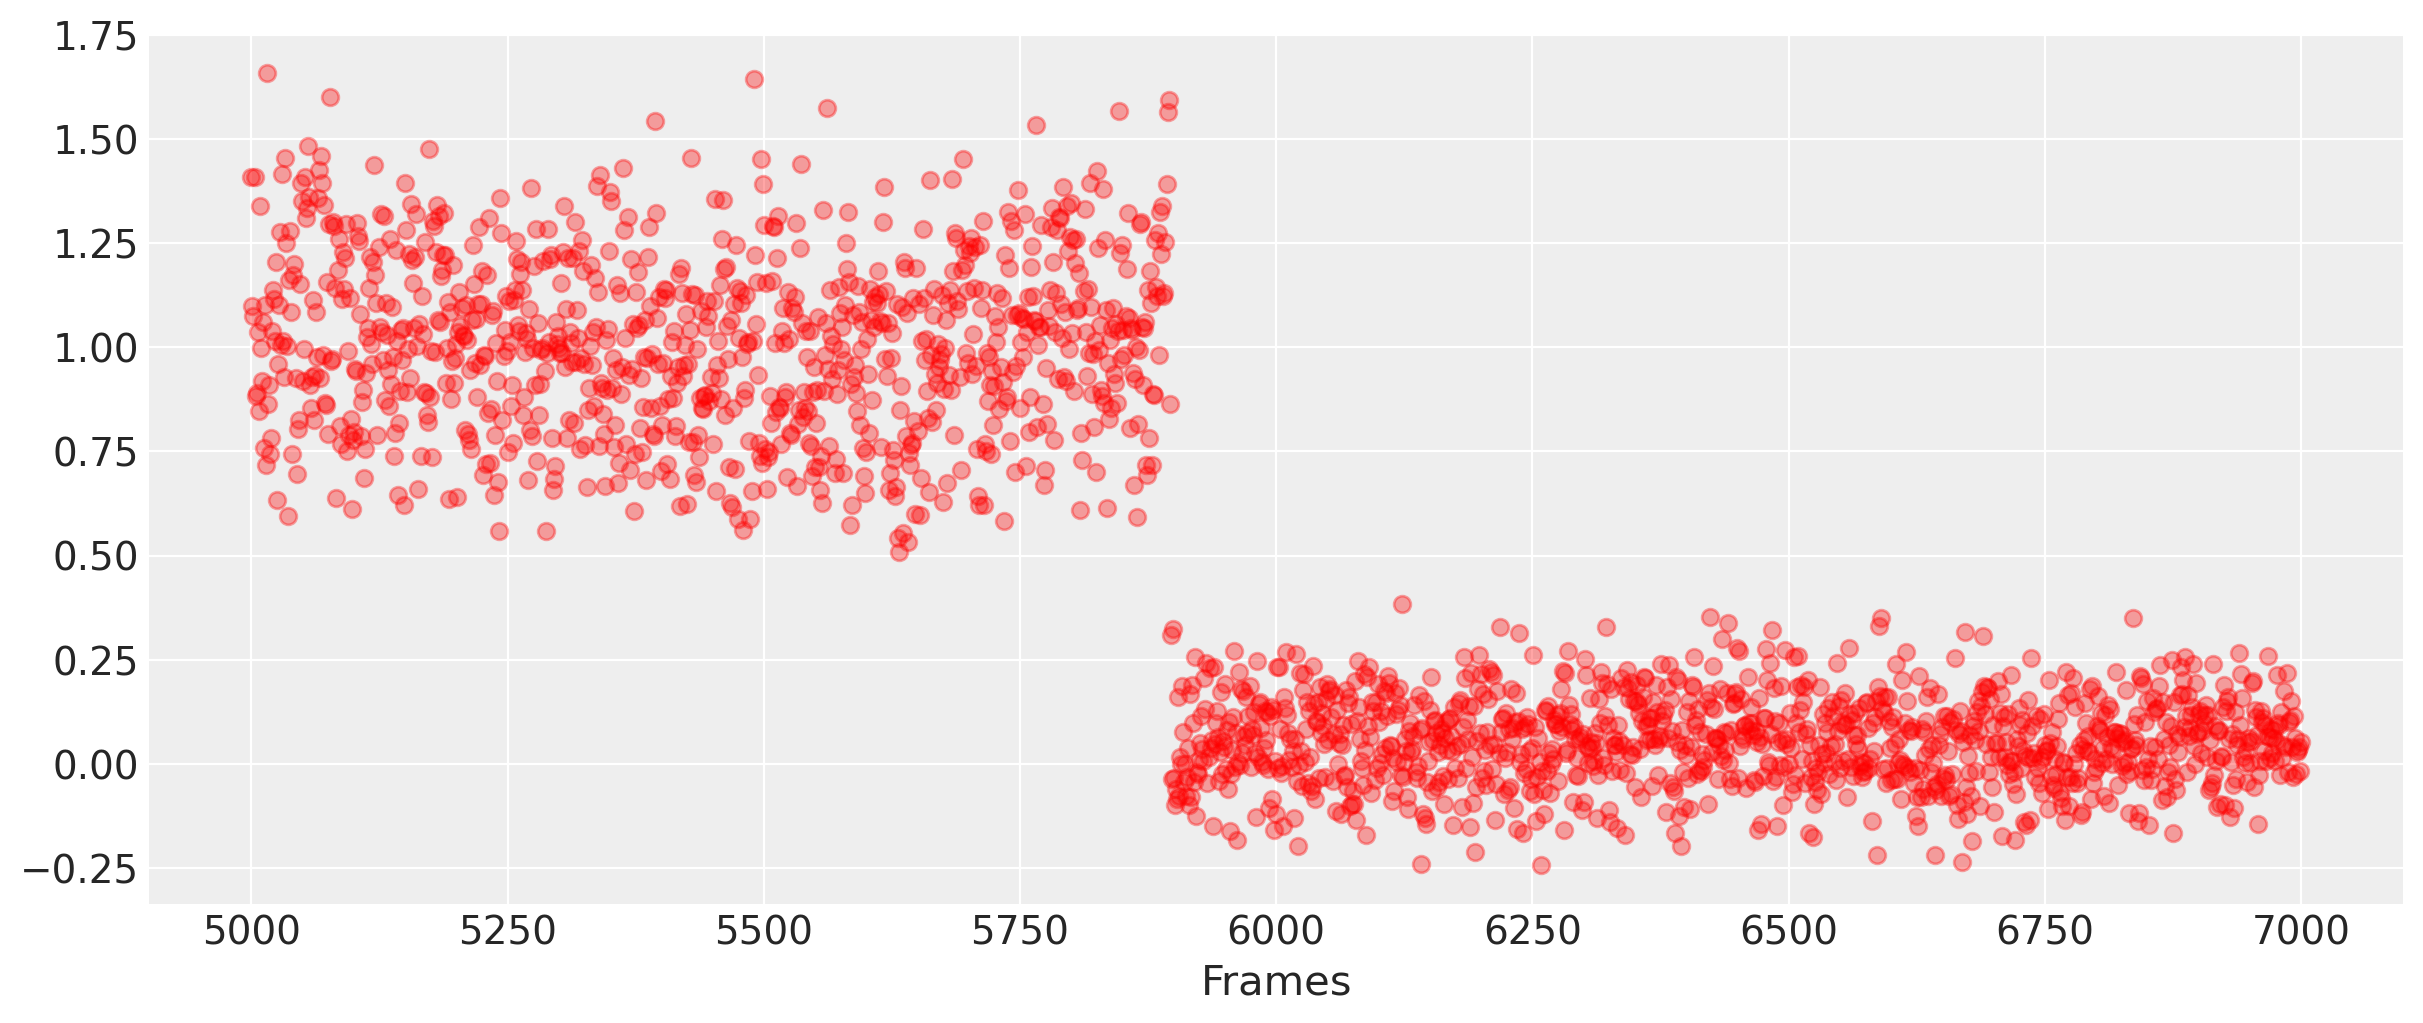

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
# ax.plot(data['frac_JD'], value_scaled, 'ro', alpha=0.35)
ax.plot(data_cp['Frame'], value_scaled, 'ro', alpha=0.35)
ax.set_xlabel('Frames')

(5750.0, 6100.0)

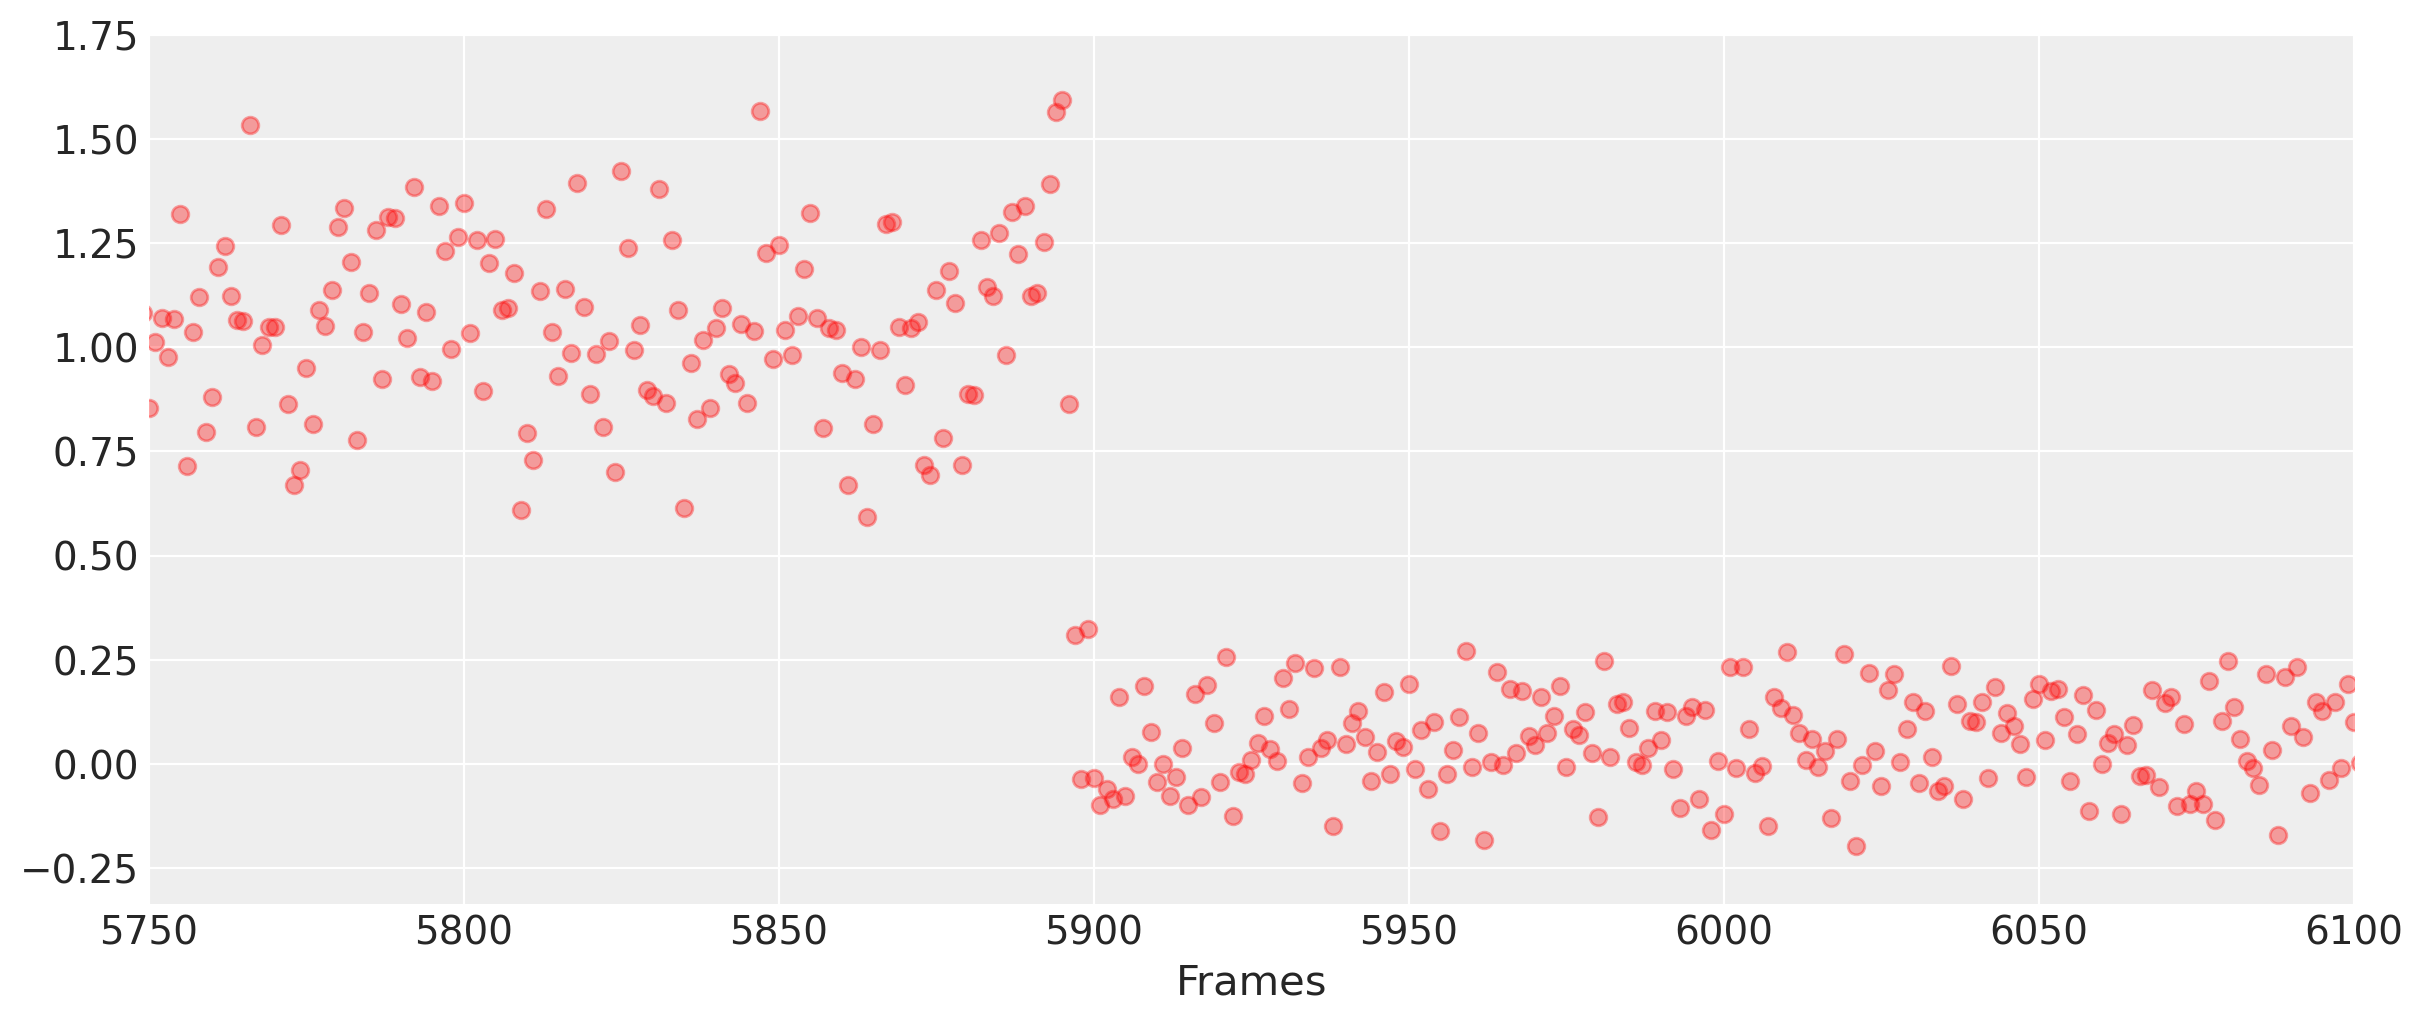

In [26]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(data_cp['Frame'], value_scaled, 'ro', alpha=0.35)
ax.set_xlabel('Frames')
ax.set_xlim(5750, 6100)

### Kurva Benda Hitam untuk HD 150366

#### Cari temperatur efektif

Temperatur efektif bintang bisa didekati dengan persamaan yang menghubungkan indeks warna bintang, $B - V$ dengan temperatur efektif bintang, $T_\mathrm{eff}$. Persamaan yang digunakan dalam pekerjaan ini diadopsi dari pekerjaan **Ballesteros 2012** (https://arxiv.org/pdf/1201.1809.pdf) sebagai berikut:

$$
T_\mathrm{eff} =  4600\left(\frac{1}{0.92 (B-V) + 1.7} + \frac{1}{0.92 (B-V) + 0.62} \right)
$$

In [11]:
# Satuan t_eff adalah Kelvin

def ballesteros(bv):
    return 4600. * ((1./(0.92*bv + 1.7)) + (1./(0.92*bv + 0.62)))

In [12]:
b = 8.015999794006348
v = 7.453000068664551

bv = b - v

teff = ballesteros(bv)
teff

6116.30037044922

In [13]:
def Planck(λ, T): 
    """
    λ: dalam cm
    T: dalam K
    """
    a = 3.7412e-5 / ((λ * 1e-7) **5) # 1e-7 adalah konversi dari nm ke cm
    b = np.exp(1.43879/(λ * 1e-7 * T)) - 1
    return a/b

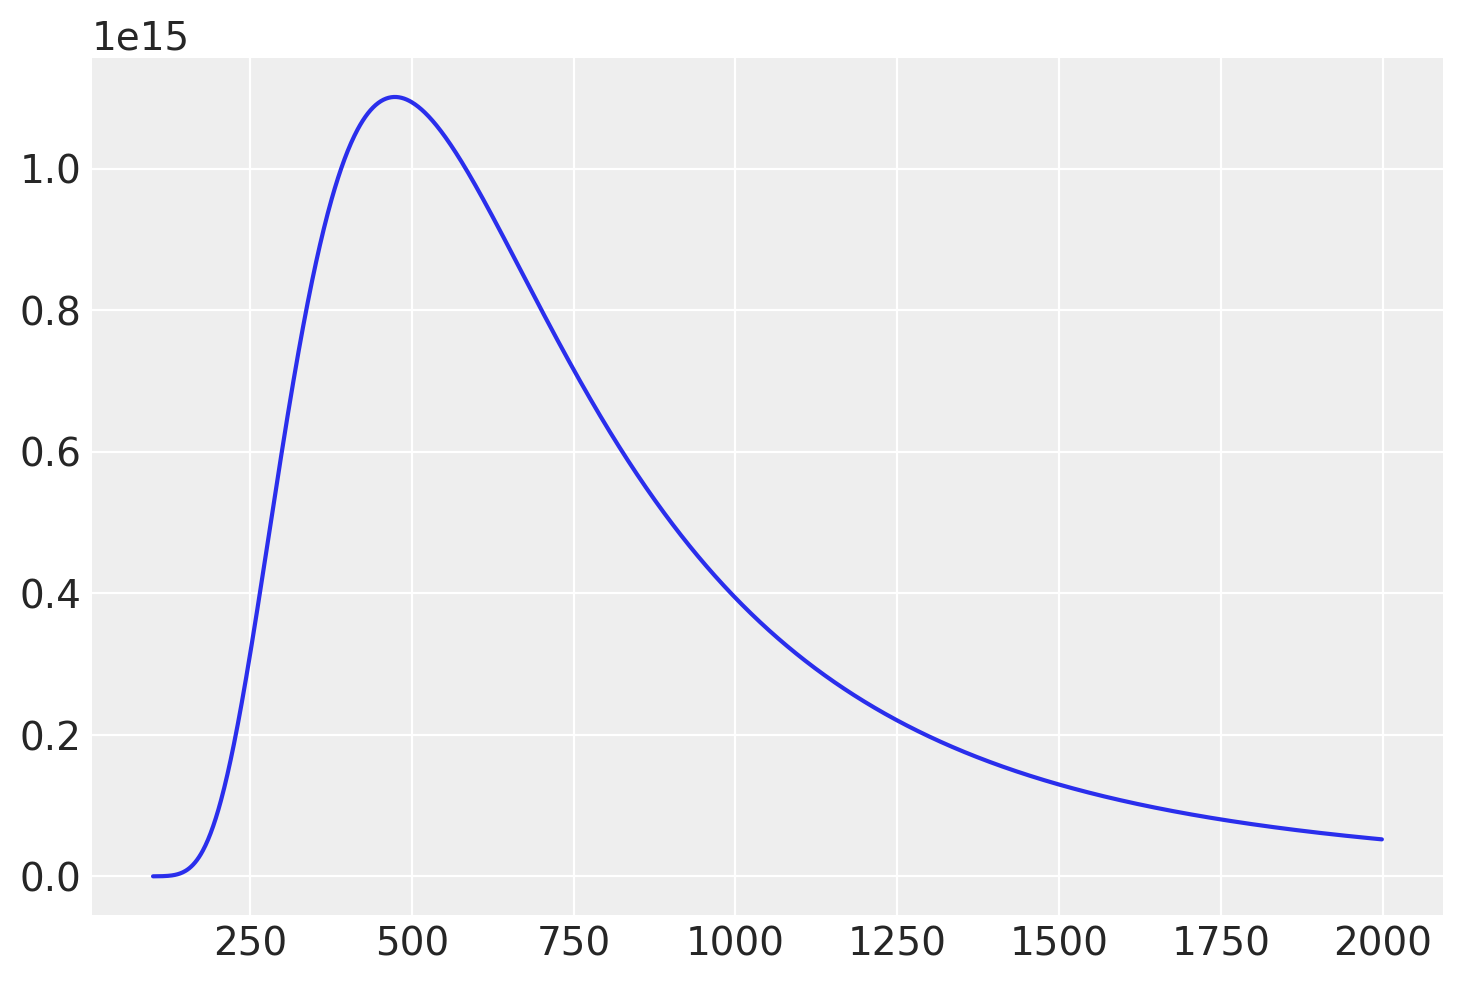

In [14]:
x_axis = np.arange(100, 2000)
y_axis = Planck(x_axis, teff)
plt.plot(x_axis, y_axis)

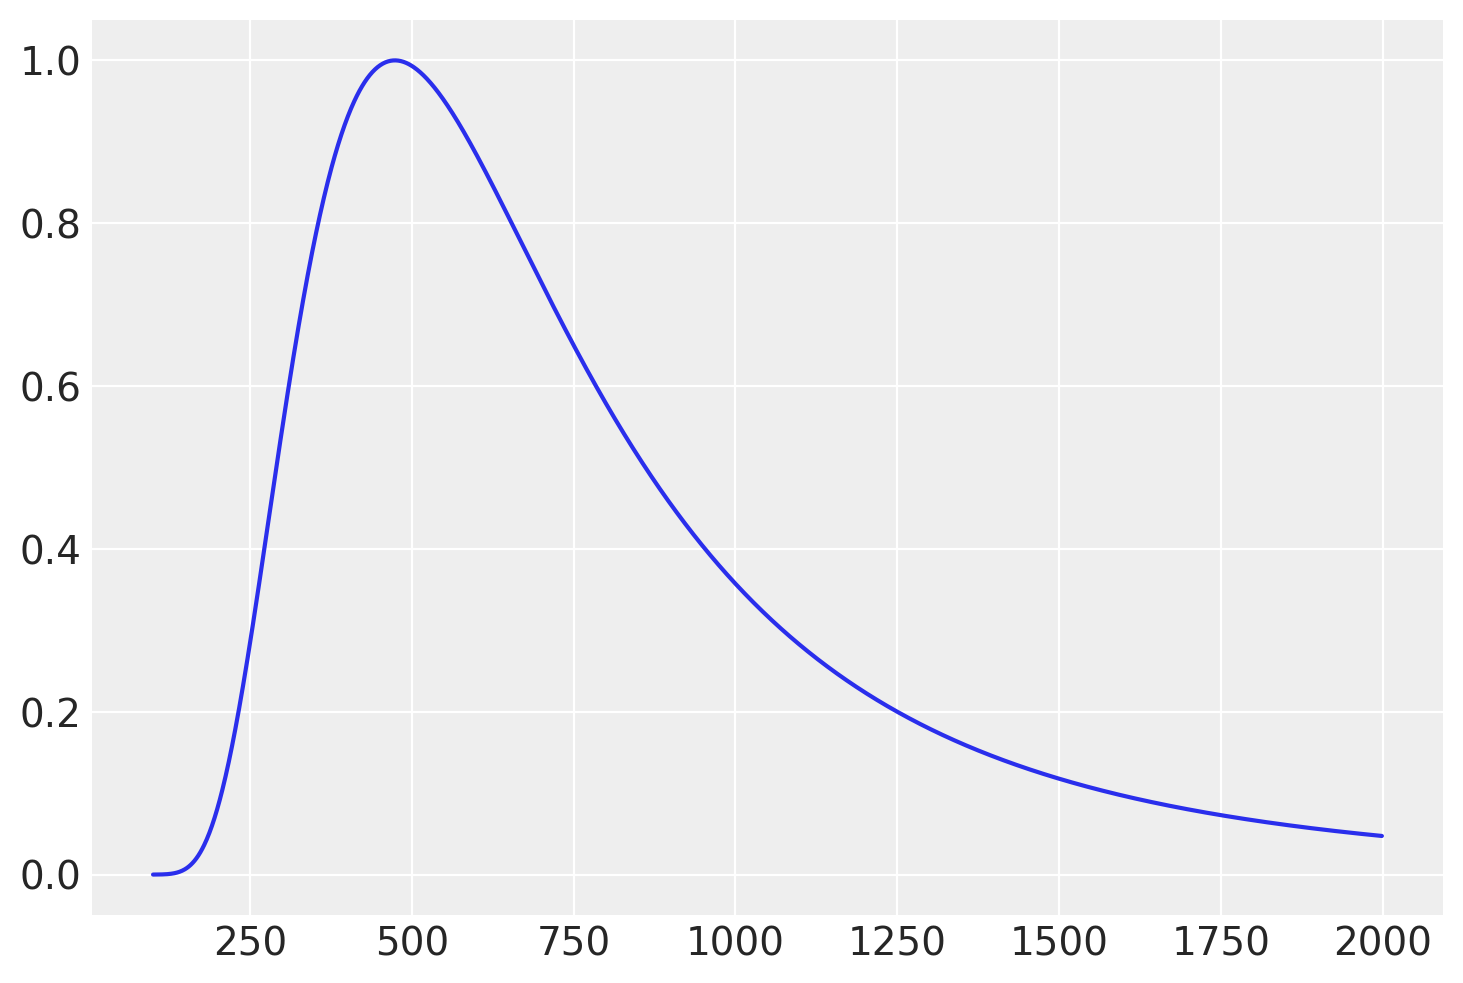

In [15]:
den = np.max(y_axis)

y_val = y_axis/den

plt.plot(x_axis, y_val)

### Kurva transmisi QHY 174M GPS *unfiltered*

In [16]:
df = pd.read_csv('qhy174_response.csv', delimiter=',', header='infer')
df.head()

wavelength  response
0       200.0       0.0
1       210.0       0.0
2       220.0       0.0
3       230.0       0.0
4       240.0       0.0

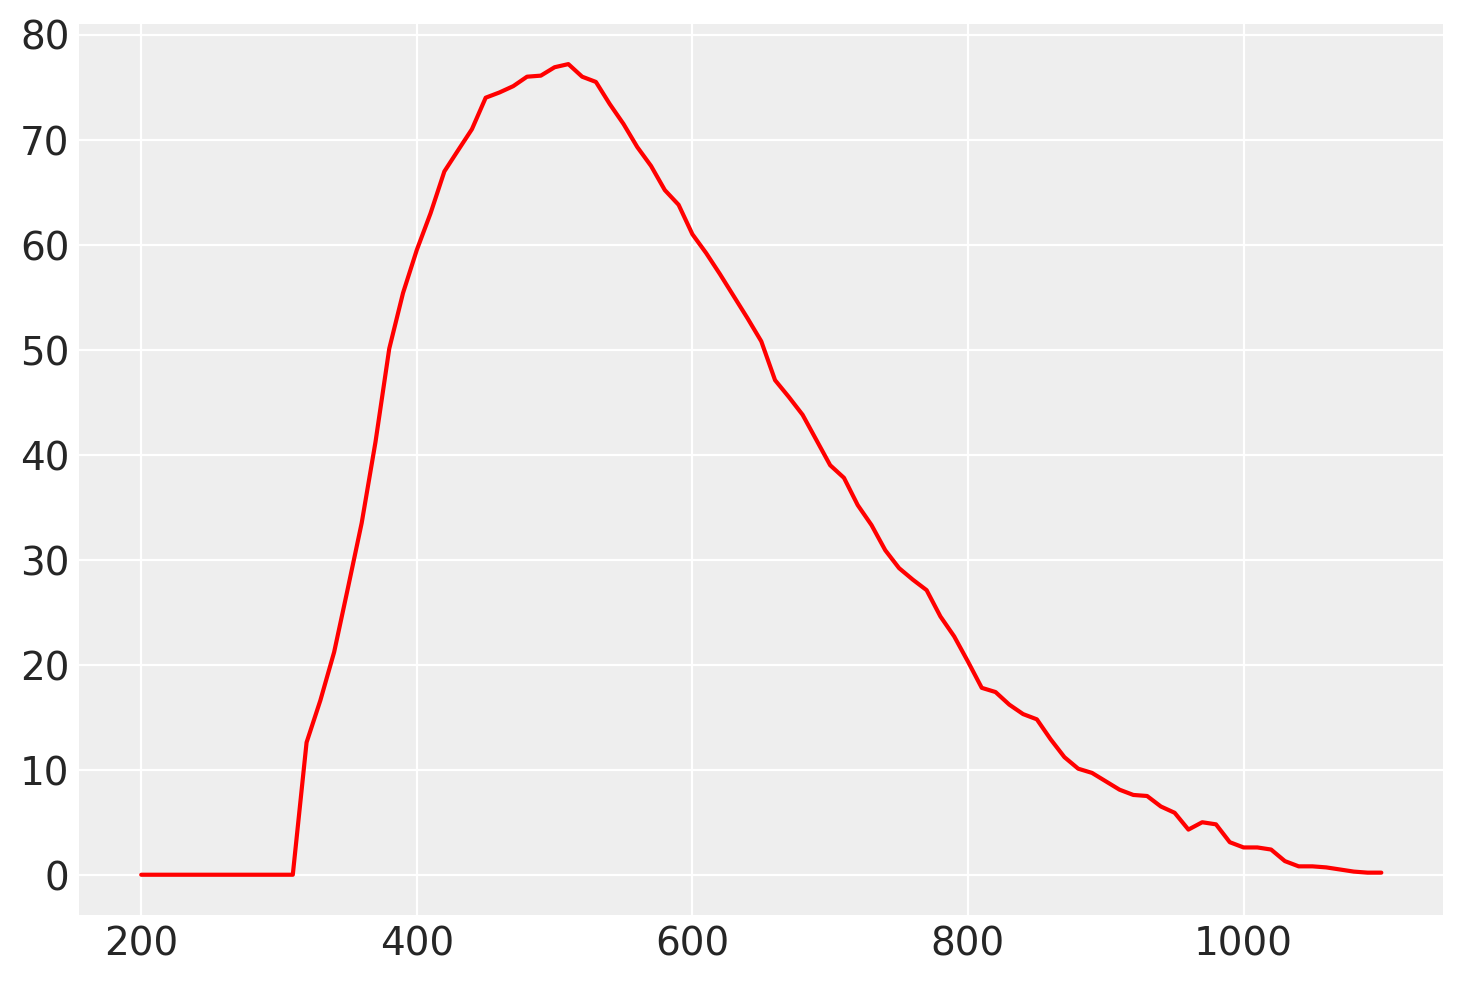

In [17]:
x = df['wavelength']
y = df['response']
plt.plot(x, y, 'r')

In [18]:
bandwidth = np.arange(330, 1100, 50) # rentang sesuai kurva transmisi
f_interp = interp1d(x, y, kind='cubic')
# bandwidth

### Jarak Bulan saat pengamatan

Pengamatan dilakukan pada tanggal **8 Agustus 2022 pukul 13:45:19 UT**. Ephemeris diambil dari https://ssd.jpl.nasa.gov/ftp/eph/planets/ascii/

In [19]:
# load timescale dan tampilkan waktu saat ini
ts = load.timescale()

# custom waktu untuk yyyy, mm, dd, hh, mm, ss
t = ts.utc(2022, 8, 8, 13, 45, 19)

In [20]:
# Load the JPL ephemeris DE430 (covers 1549-2650) dan cari jarak Bumi-Bulan
planets = load('de430.bsp')
earth, moon = planets['earth'], planets['moon']

In [21]:
# posisi Bulan dari Bumi
astrometric = earth.at(t).observe(moon)
ra, dec, distance = astrometric.radec()

In [22]:
# tampilkan koordinat Bulan dan jarak Bulan dalam AU
print(ra)
print(dec)
print(distance.km)

17h 45m 11.58s
-26deg 32' 20.5"
363492.4987936911


In [23]:
d_moon = distance.km
d_moon

363492.4987936911

## Inisiasi model

In [24]:
x_data = np.array(data_cp['Frame'])
y_data = np.array(data_cp['Value'])
# y_data = np.array(value_scaled)

In [25]:
def fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        # model untuk disappearance
        cc, ss = sc.fresnel(-w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        # y_new = f_interp(bandwidth[i]) * y
        y0 += y_new
    return y0

In [27]:
# Variabel benar
# -------------
x0_true = 5890
A_true = 1.
σ_true = 50.
T = teff

In [28]:
y_syn = fresnel_polikromatik(x_data, x0_true, d_moon, A_true)
y_syn = np.random.normal(y_syn, scale=σ_true)

y_syn_scaled = y_syn / (y_syn.std()*2)

Text(0, 0.5, 'Intensity')

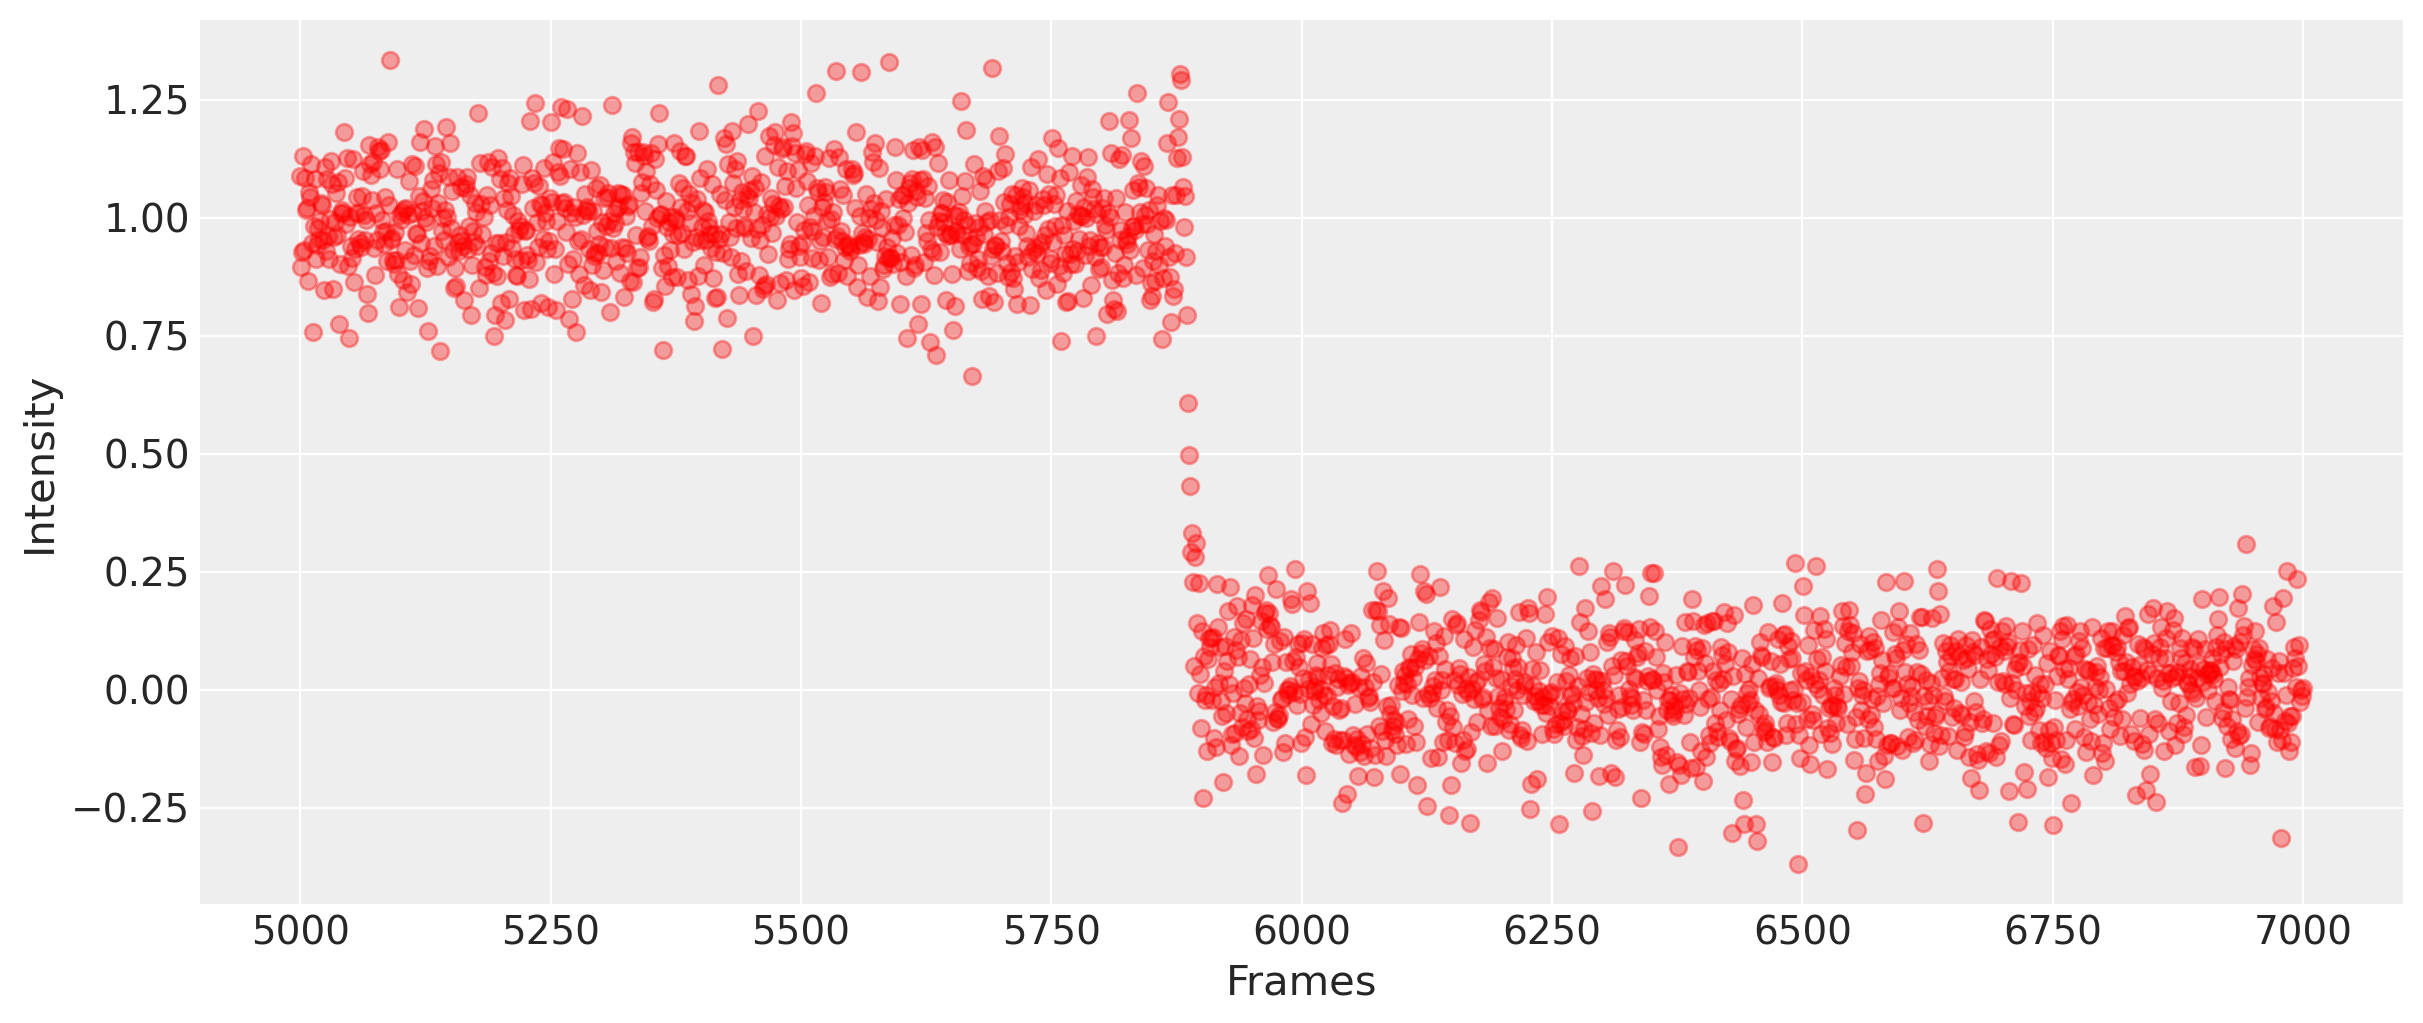

In [29]:
plt.figure(figsize = (12,5), facecolor='w')
plt.scatter(x_data, y_syn_scaled, marker='o', c='r', alpha=0.35)
# plt.invert_yaxis()
# plt.xlim(6800, 7200)
plt.xlabel('Frames')
plt.ylabel('Intensity')

In [30]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(-w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        y0 += y_new
    return y0

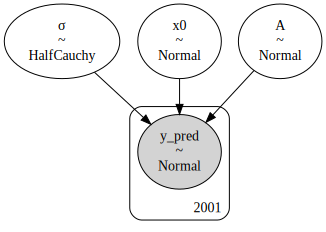

In [44]:
x_shared = aesara.shared(x_data)
d_shared = aesara.shared(d_moon)

with pm.Model() as model_polikromatik:
    A = pm.Normal('A', mu=1., sigma=20.)
    σ = pm.HalfCauchy('σ', beta=20.)
    x0 = pm.Normal('x0', mu=5890., sigma=10.)
    
    μ = t_fresnel_polikromatik(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=value_scaled)
    
pm.model_to_graphviz(model_polikromatik)

In [45]:
with model_polikromatik:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 317 seconds.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

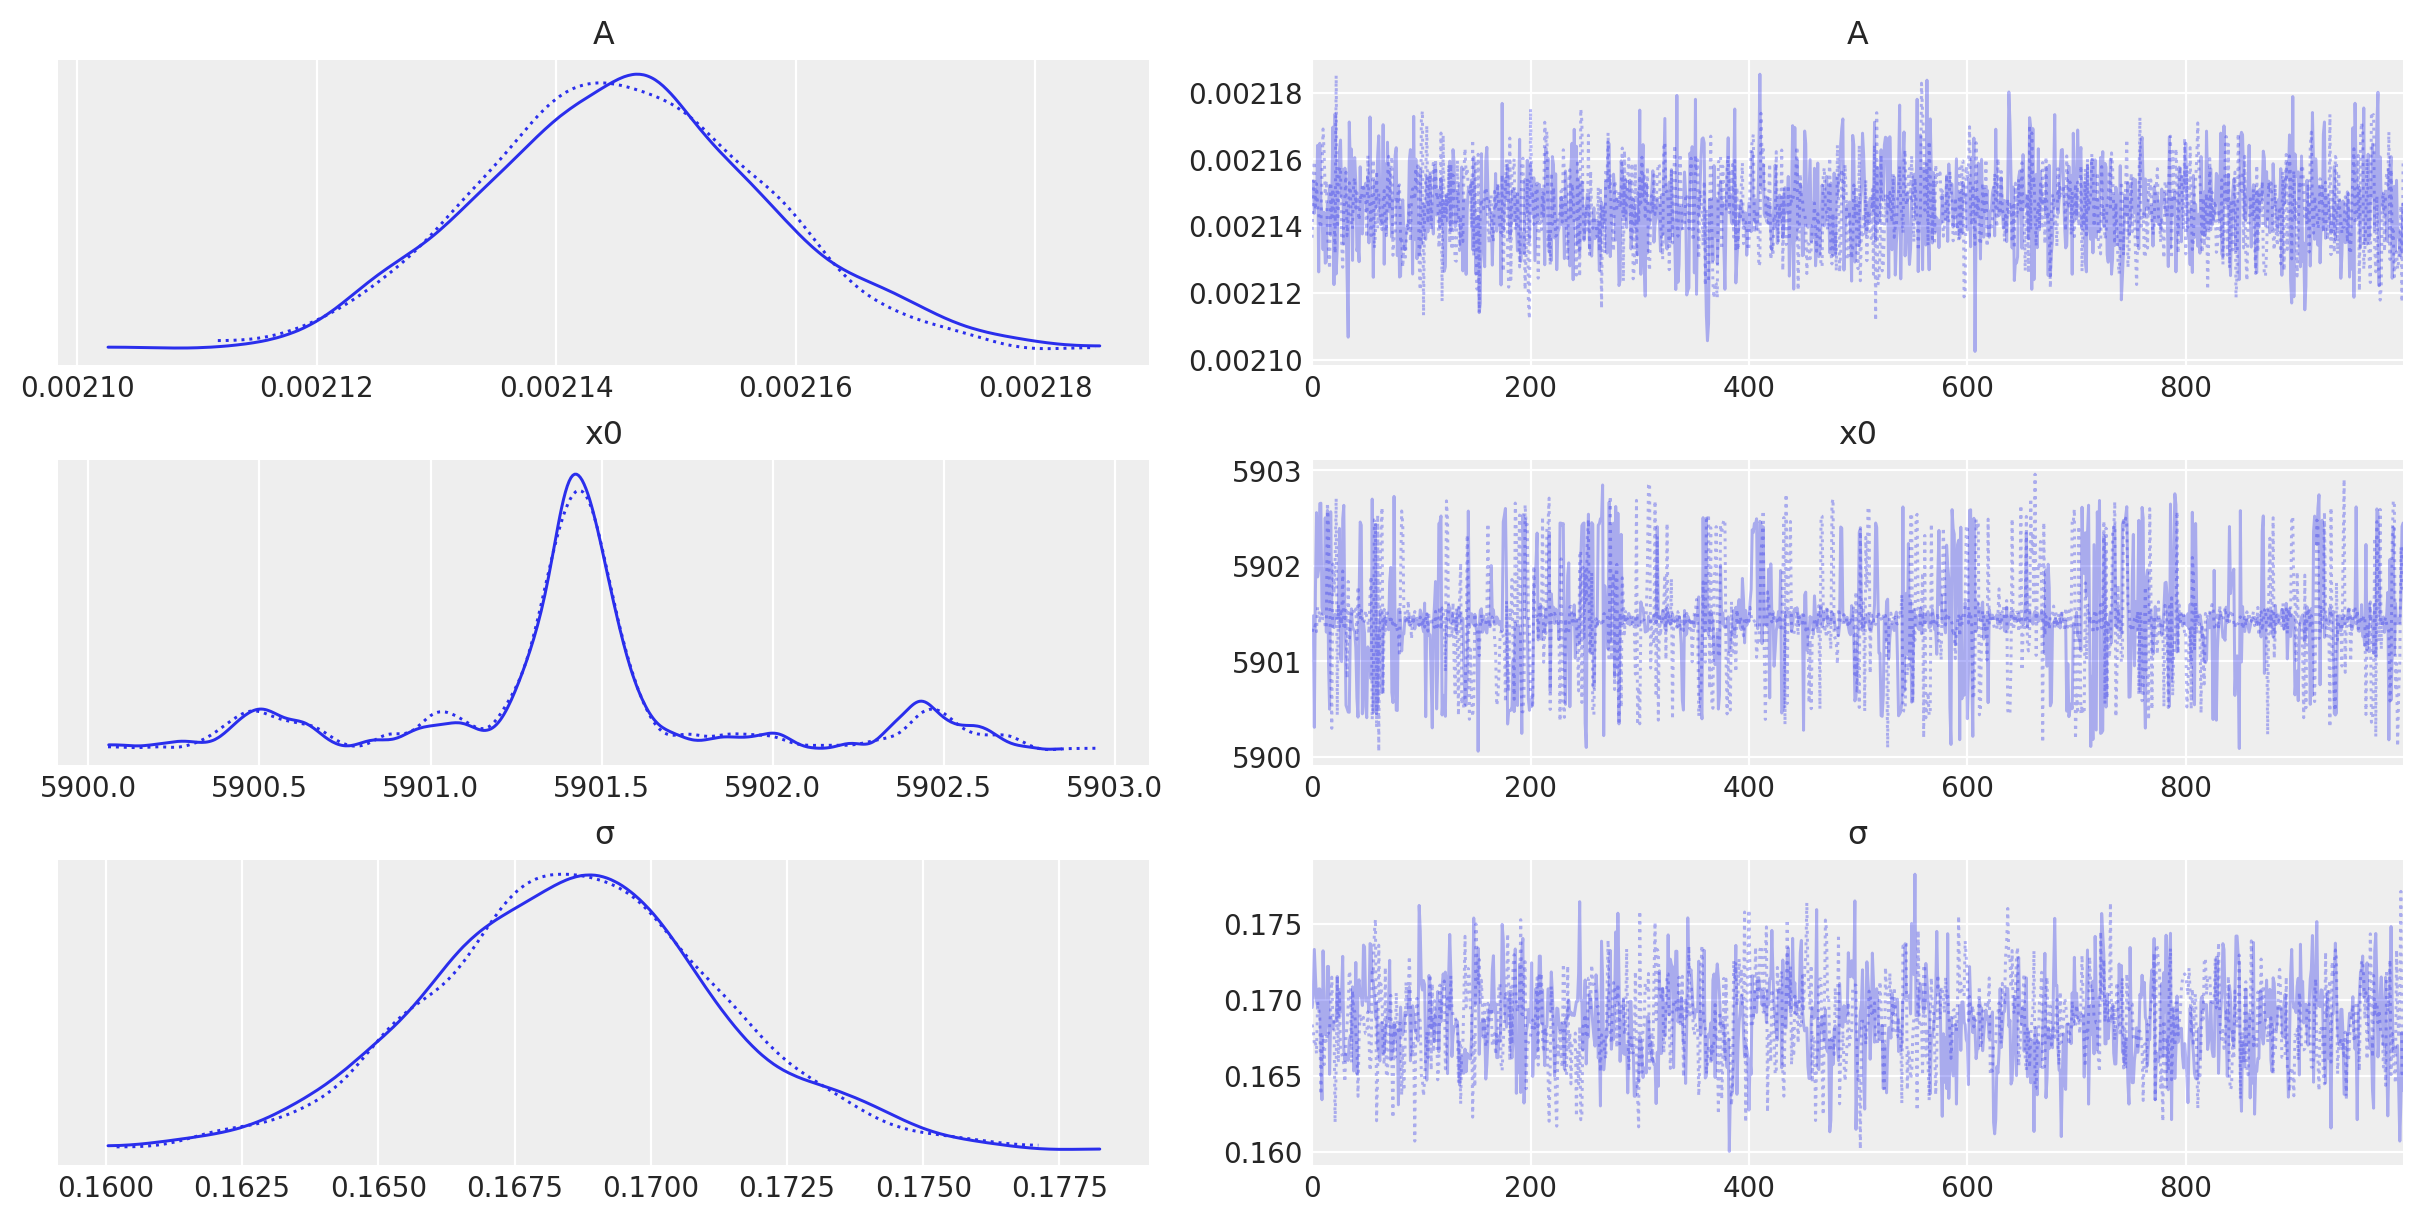

In [46]:
az.plot_trace(idata)

In [47]:
az.summary(idata)

mean    sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
A     0.002   0.0    0.002    0.002        0.0      0.0    2054.0    1270.0   
x0 5901.431 0.523 5900.407  5902.54      0.014     0.01    1585.0    1299.0   
σ     0.169 0.003    0.163    0.174        0.0      0.0     718.0    1601.0   

    r_hat  
A     1.0  
x0    1.0  
σ     1.0

In [48]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

C:\Users\User\AppData\Local\Temp\ipykernel_3964\1895824516.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


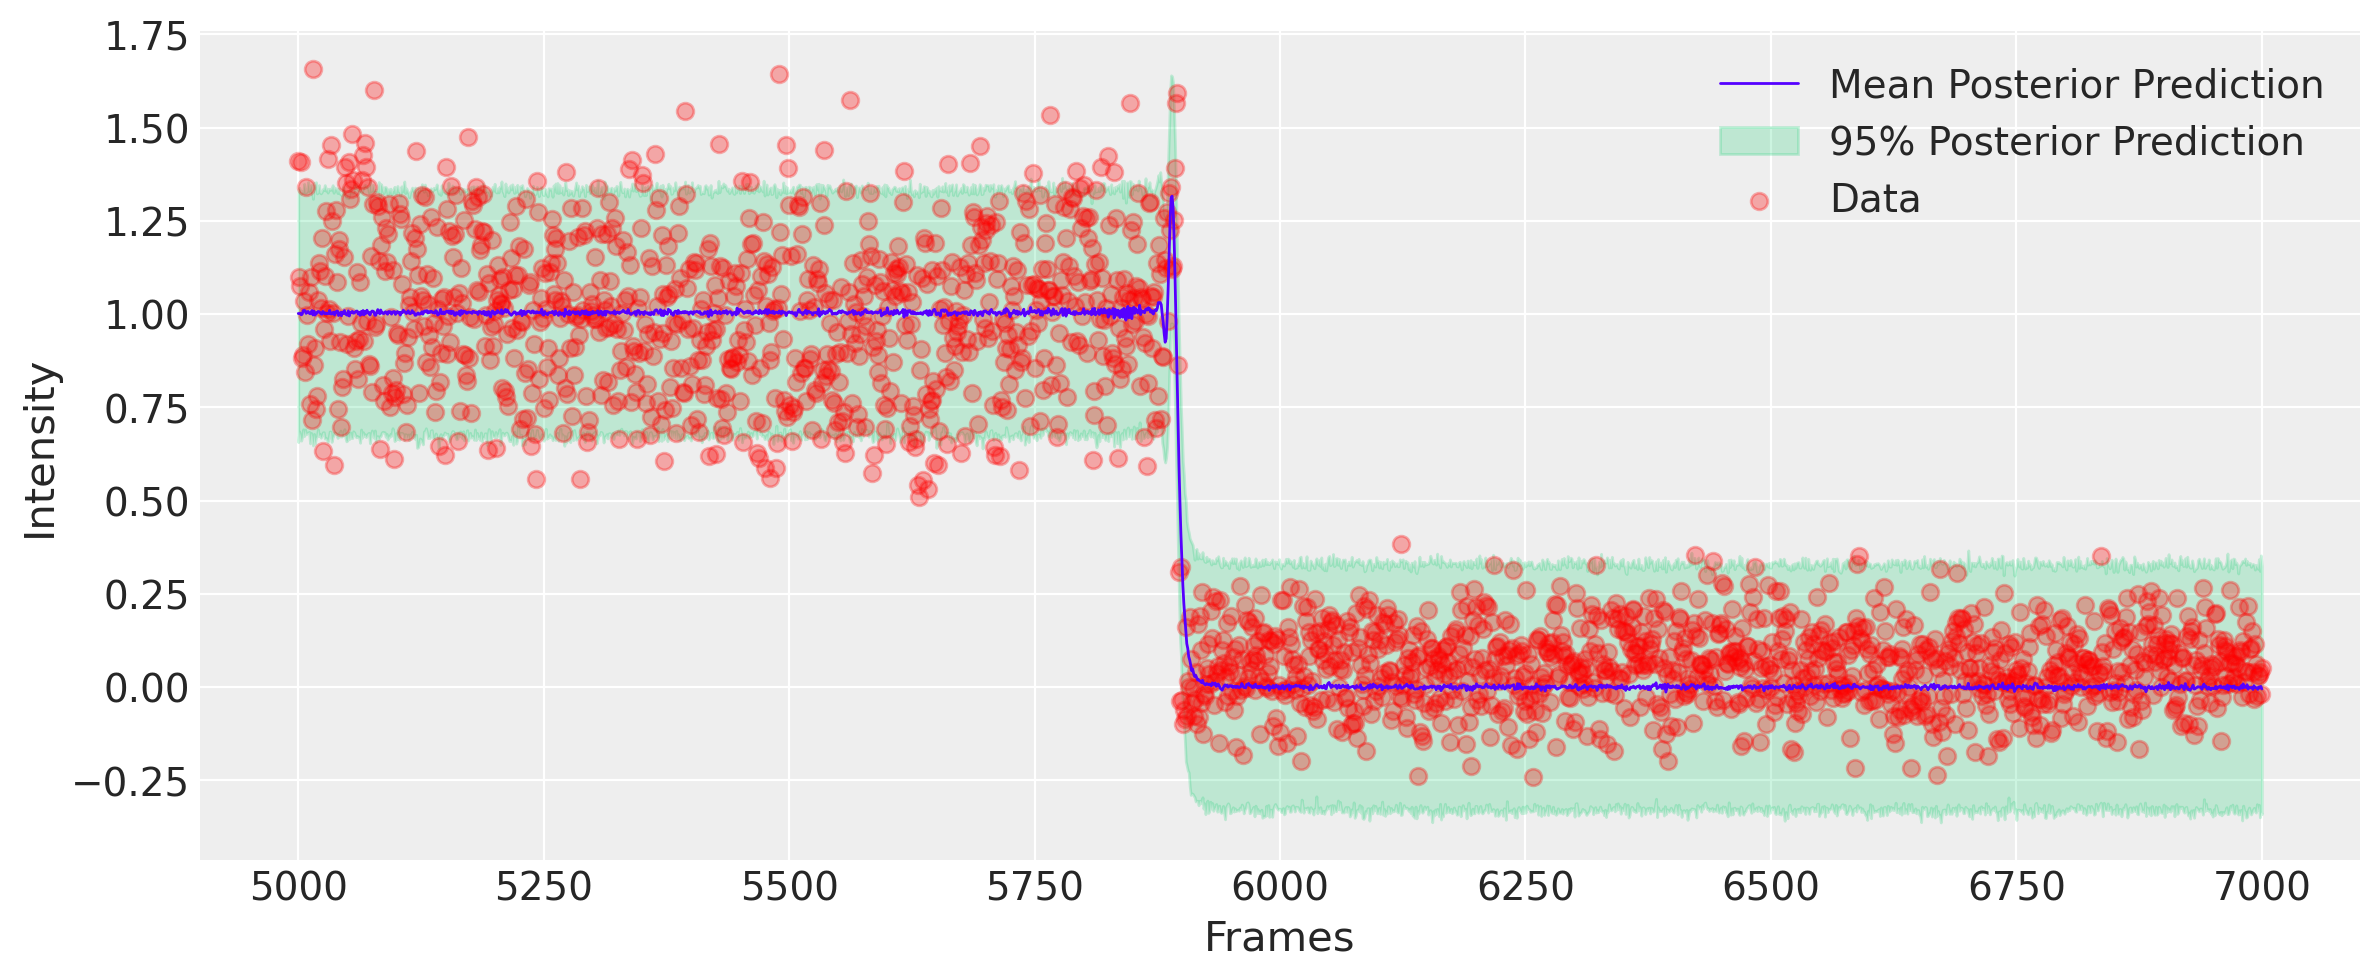

In [49]:
plt.figure(figsize=(12,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, value_scaled, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
# plt.xlim(3250, 3500)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Data'], loc='upper right')

### Konversi *Frame Number* ke waktu

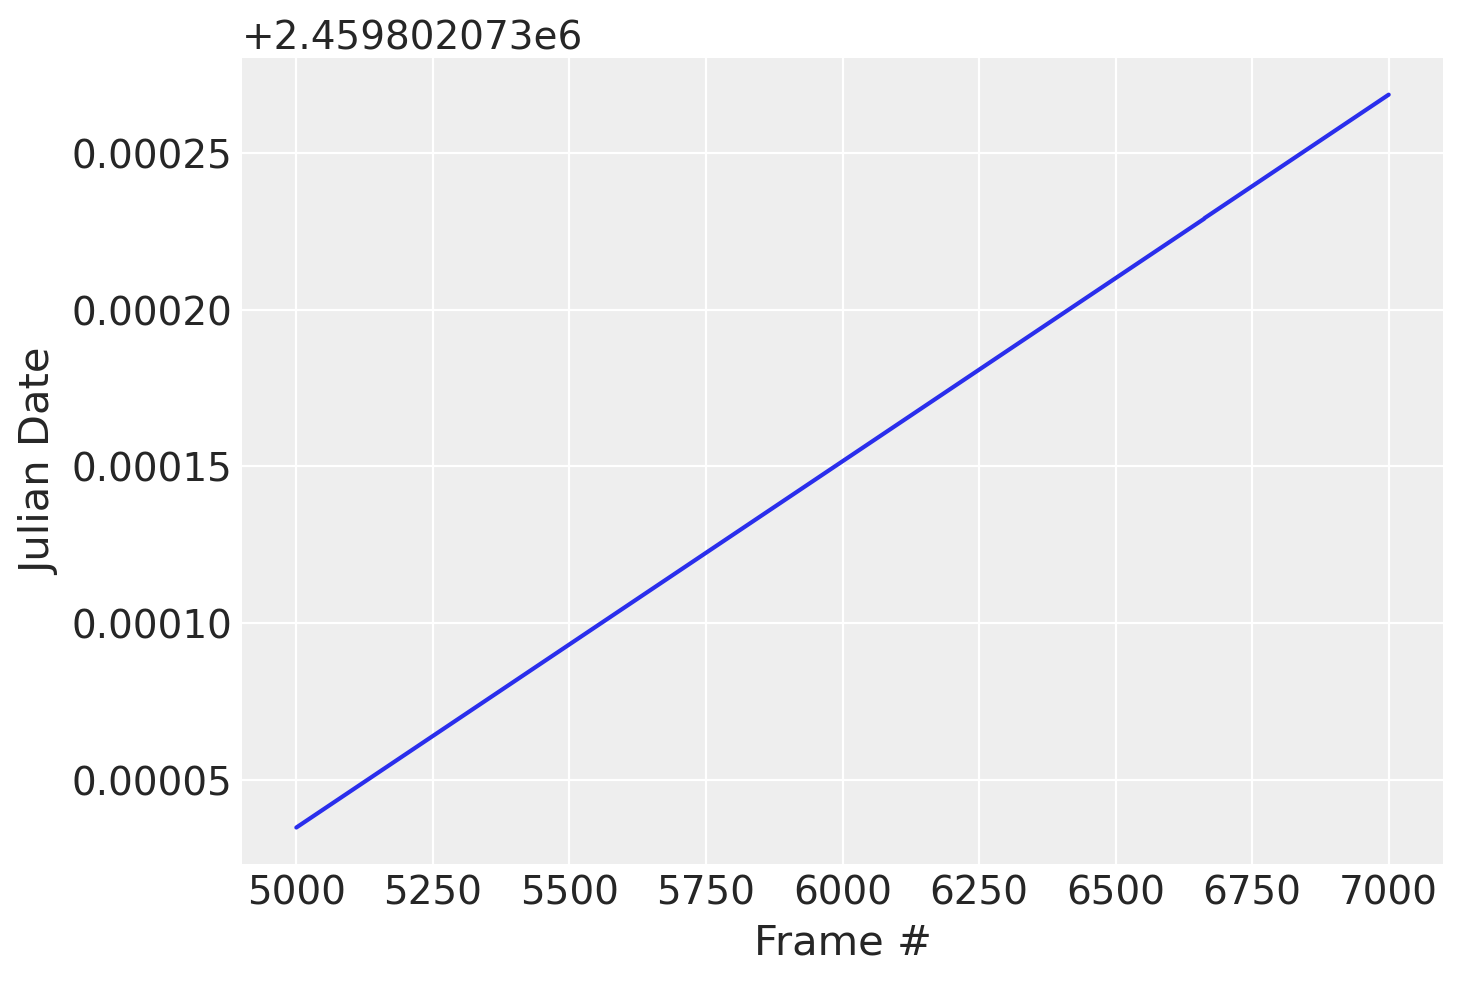

In [50]:
x = data_cp['Frame']
y = data_cp['JD']

plt.plot(x, y)
plt.xlabel('Frame #')
plt.ylabel('Julian Date')

f = interp1d(x, y, kind='cubic')

In [51]:
framenum = idata.posterior.mean().x0.values

# interpolasi

date = f(framenum)
type(date)

date_str = np.array_str(date)
date_str

# Ubah ke format waktu

j_date = Time(date_str, format='jd')
# j_date.value
iso_time = j_date.iso
iso_time

t_iso_time = pd.to_datetime(iso_time)
t_iso_time.time()

datetime.time(13, 45, 19, 306000)

In [52]:
data_cp

Frame                       Date   Value                 JD  \
0    5000.0 2022-08-10 13:45:10.201339 95143.0 2459802.0730347377   
1    5001.0 2022-08-10 13:45:10.211438 74148.0 2459802.0730348546   
2    5002.0 2022-08-10 13:45:10.221538 72501.0 2459802.0730349715   
3    5003.0 2022-08-10 13:45:10.231638 95052.0 2459802.0730350884   
4    5004.0 2022-08-10 13:45:10.241737 59529.0 2459802.0730352052   
...     ...                        ...     ...                ...   
1996 6996.0 2022-08-10 13:45:30.370452  2011.0 2459802.0732681765   
1997 6997.0 2022-08-10 13:45:30.380552  2242.0 2459802.0732682934   
1998 6998.0 2022-08-10 13:45:30.390652  2700.0 2459802.0732684103   
1999 6999.0 2022-08-10 13:45:30.400751 -1193.0  2459802.073268527   
2000 7000.0 2022-08-10 13:45:30.410851  3546.0  2459802.073268644   

                 frac_JD  
0    0.07303473772481084  
1    0.07303485460579395  
2    0.07303497148677707  
3    0.07303508836776018  
4     0.0730352052487433  
...                  ...  
1996 0.07326817652210593  
1997 0.07326829340308905  
1998 0.07326841028407216  
1999 0.07326852716505527  
2000 0.07326864404603839  

[2001 rows x 5 columns]

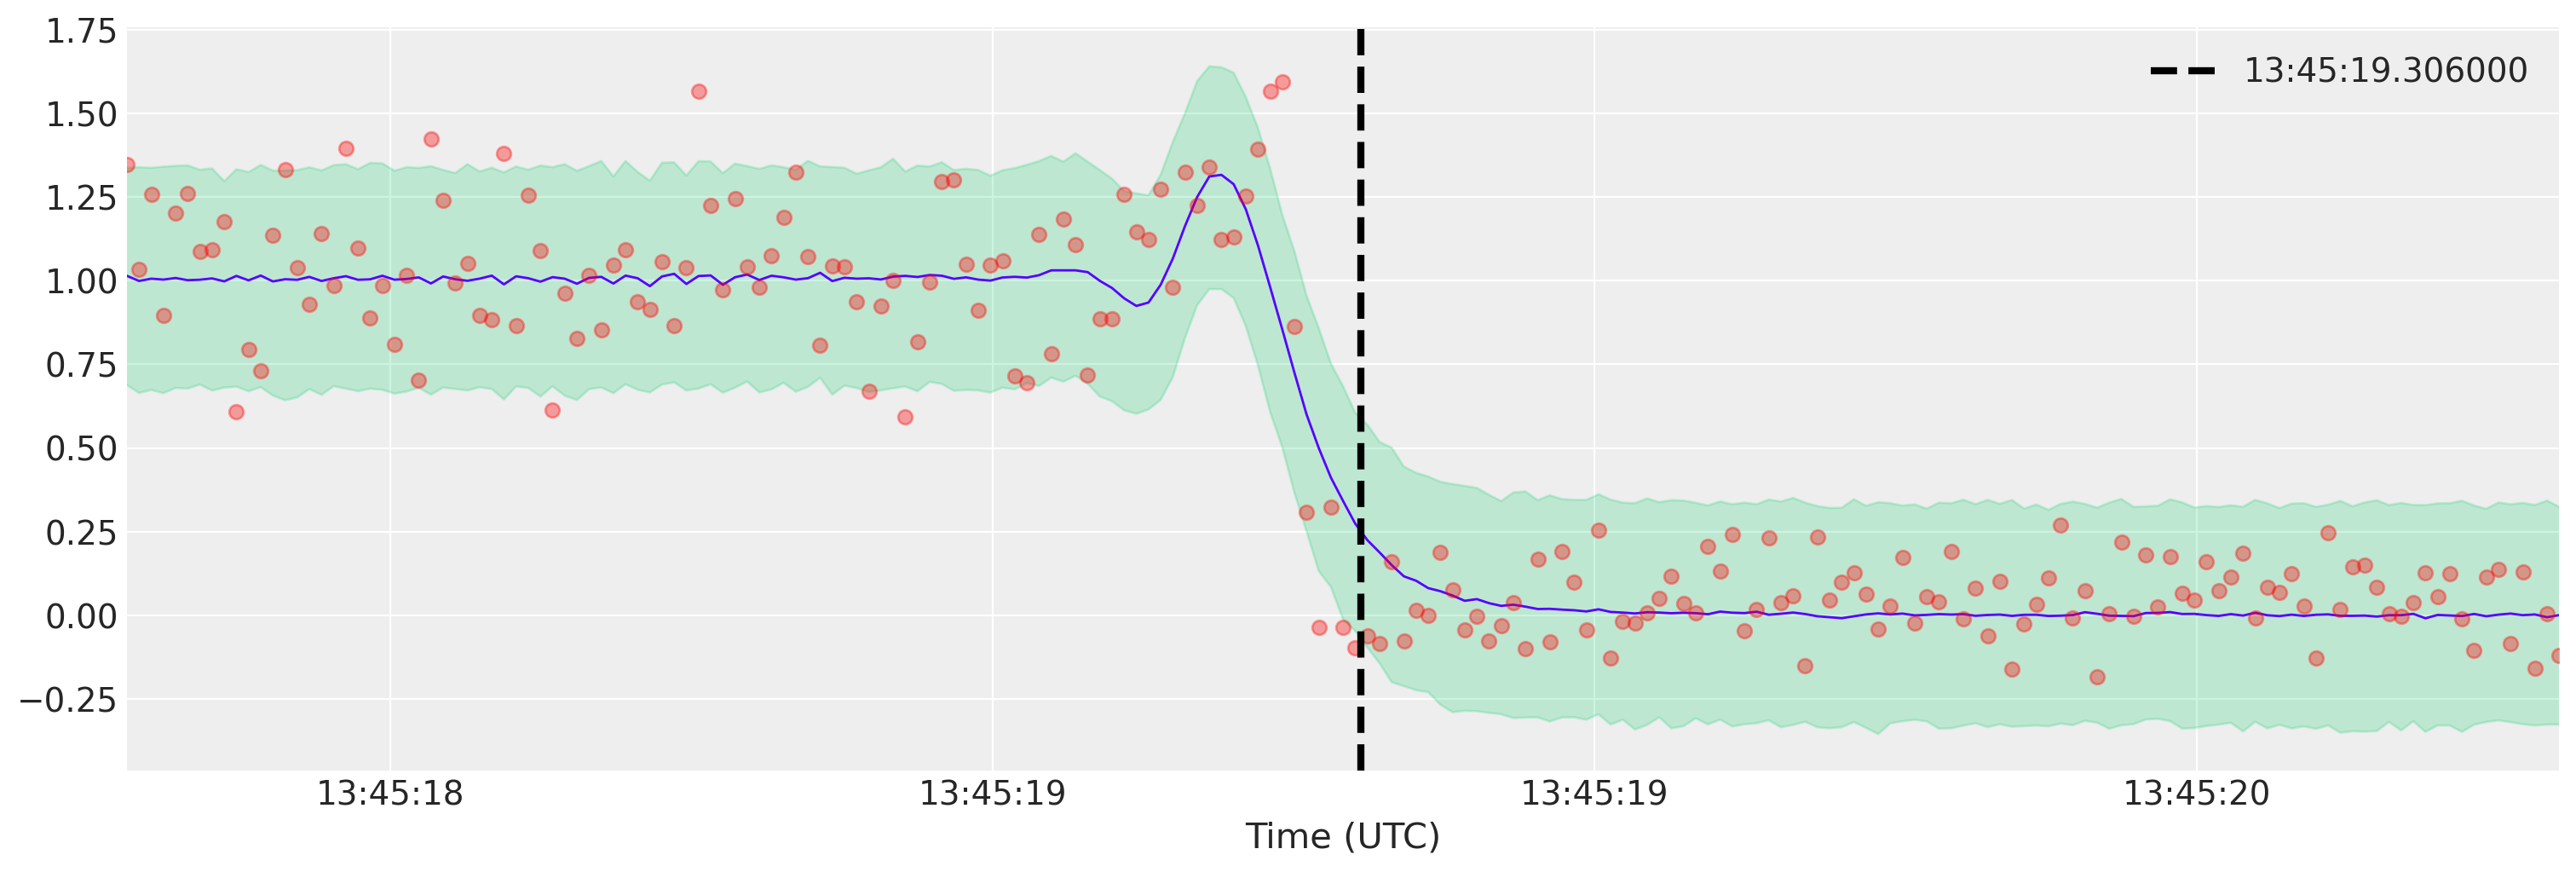

In [53]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data_cp['Date'], mean_spp, linestyle='-', linewidth=1, color="#5500ff")
ax.fill_between(data_cp['Date'], crit_l, crit_u, alpha=0.2, color="#00cc66")
ax.plot(data_cp['Date'], value_scaled, 'ro', alpha=0.35)
# ax.plot(data['Time'], y_filtered, 'ro', alpha=0.35)

plt.axvline(x = t_iso_time, color = 'k', lw=3, ls='--', label = t_iso_time.time())
plt.legend(loc = 'upper right')

#ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlim(data_cp['Date'][800], data_cp['Date'][1000]) # baris ke-# untuk kolom 'Time'
ax.set_xlabel('Time (UTC)')

date_form = mdates.DateFormatter("%H:%M:%S")#, tz=pytz.timezone(‘Australia/Sydney’))
#ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
#ax.xaxis.set_major_locator(mdates.HourLocator(byhour=None, interval=2))
ax.xaxis.set_major_formatter(date_form)
# ax.tick_params('x', labelrotation=45)

# data['Time'].dt.hour()

<AxesSubplot:xlabel='y_pred / y_pred'>

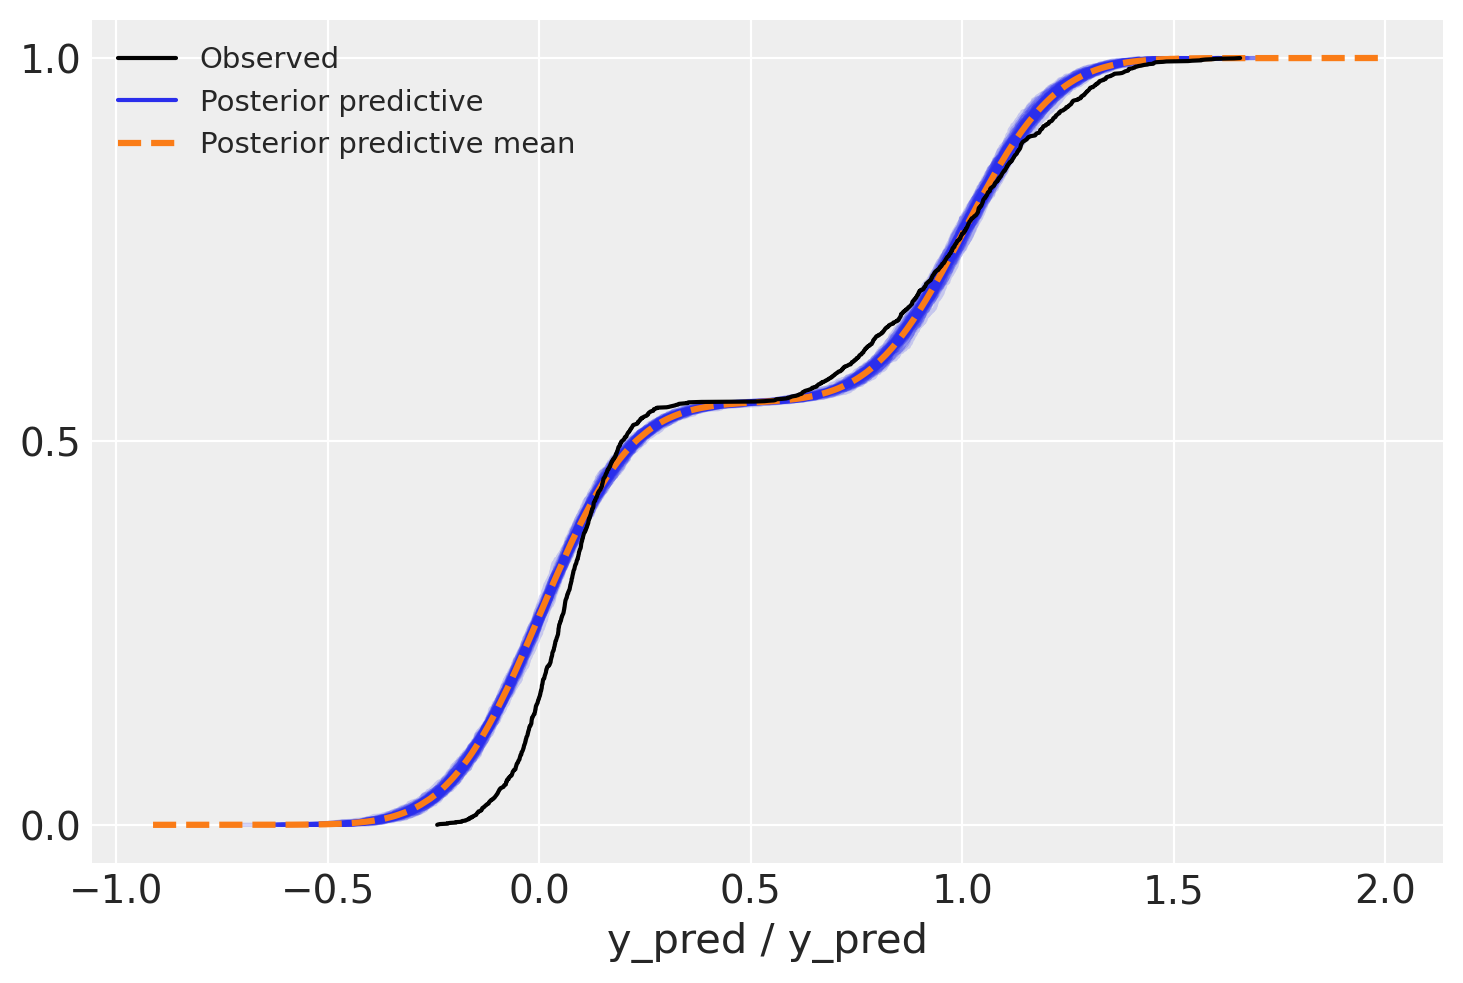

In [54]:
az.plot_ppc(idata, num_pp_samples=100, kind='cumulative')